In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def read_all_data():
    data = pd.read_csv('train.csv')
    store = pd.read_csv('store.csv')
    test = pd.read_csv('test.csv')
    sample = pd.read_csv('sample_submission.csv')
    return data, test, store, sample

In [4]:
train_df,test_df,store_df,sample = read_all_data()

In [5]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [6]:
def date_comp_column_duration(data):
    mon=int(data["CompetitionOpenSinceMonth"])
    year=int(data["CompetitionOpenSinceYear"])
    store_date=data["Date"]
    if (mon==0)&(year==0):
        return 0
    else:
        date=datetime.strptime((str(1)+" "+str(mon)+" "+str(year)),"%d %m %Y")
        if date<store_date:
            return (store_date-date).days
        else:
            return 1

In [7]:
def date_comp_column(data):
    mon=int(data["CompetitionOpenSinceMonth"])
    year=int(data["CompetitionOpenSinceYear"])
    store_date=data["Date"]
    if (mon==0)&(year==0):
        return 0
    else:
        date=datetime.strptime((str(1)+" "+str(mon)+" "+str(year)),"%d %m %Y")
        if date>store_date:
            return 0
        else:
            return 1

In [8]:
def groupby_operations():
    data=pd.read_csv("train.csv")
    df=train_df.groupby(["Store","DayOfWeek","Promo"]).agg({"Customers":[np.mean,np.median]})
    df.columns=["Cust_mean","Cust_Median"]
    df=df.reset_index()
    return df

In [9]:
def null_store_impute(data):
    data["CompetitionDistance"]=data["CompetitionDistance"].fillna(0)
    data["CompetitionOpenSinceMonth"]=data["CompetitionOpenSinceMonth"].fillna(0)
    data["CompetitionOpenSinceYear"]=data["CompetitionOpenSinceYear"].fillna(0)
    data["Promo2SinceWeek"]=data["Promo2SinceWeek"].fillna(0)
    data["Promo2SinceYear"]=data["Promo2SinceYear"].fillna(0)
    data["PromoInterval"]=data["PromoInterval"].fillna(0)
    return data

In [10]:
def data_operation(data,store):
    store_df=null_store_impute(store)
    data["Date"]=pd.to_datetime(data["Date"])
    data["Month"]=data["Date"].dt.month
    data["Day"]=data["Date"].dt.day
    data["Year"]=data["Date"].dt.year
    data["StateHoliday"]=data["StateHoliday"].map({"0":0,0:0,"a":1,"b":2,"c":3})
    data_merged=pd.merge(left=data,right=store,how="inner")
    return data_merged

In [11]:
def date_comp_column(data):
    mon=int(data["CompetitionOpenSinceMonth"])
    year=int(data["CompetitionOpenSinceYear"])
    store_date=data["Date"]
    if (mon==0)&(year==0):
        return 0
    else:
        date=datetime.strptime((str(1)+" "+str(mon)+" "+str(year)),"%d %m %Y")
        if date>store_date:
            return 0
        else:
            return 1

In [12]:
train_df=data_operation(train_df,store_df)
test_df=data_operation(test_df,store_df)

In [13]:
def feature_engineering(data):
    data['is_december'] = data['Month'].apply(lambda v: 1 if v==12 else 0)
    data['is_state_holiday_flg'] = data['StateHoliday'].apply(lambda v: 0 if v==0 else 1)
    data['is_holiday'] = data['is_state_holiday_flg'] * data['SchoolHoliday']
    #data["Month_Promo"]=data["Month"].apply(lambda x:1 if x in [11,8,10,9,12] else 0)
    data["Competition_Flag"]=data["CompetitionDistance"].apply(lambda x:0 if x==0 else 1)
    data["Promo_Flag"]=data["Promo2SinceYear"].apply(lambda x:0 if x==0 else 1)
    customer_cols=groupby_operations()
    data=pd.merge(on=["Store","DayOfWeek","Promo"],left=data,right=customer_cols,how="left")
    data["Missing_Features"]=(data==0).sum(axis=1)
    data["Comp_Opened_Before"]=data[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear',"Date"]].apply(date_comp_column,axis=1)
    data["Compettition_Opened_Before_Duration"]=data[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear',"Date"]].apply(date_comp_column_duration,axis=1)
    data["CompetitionDistance_split"]=pd.qcut(data["CompetitionDistance"],5,labels=[1,2,3,4,5])
    return data

In [14]:
train_df=feature_engineering(train_df)
test_df=feature_engineering(test_df)

In [15]:
train_df = train_df[train_df['Open'] != 0]

In [16]:
train_dummies=pd.get_dummies(data=train_df.drop("Date",axis=1),drop_first=True)
test_dummies=pd.get_dummies(data=test_df.drop("Date",axis=1),drop_first=True)

In [17]:
X=train_dummies.drop(columns=['Sales','Customers'])
y=train_dummies["Sales"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [19]:
model=lgb.LGBMRegressor(max_depth=10)

model.fit(X_train,y_train)

pred=model.predict(X_test)

mean_squared_error(y_test,pred)**.5

1083.337175811585

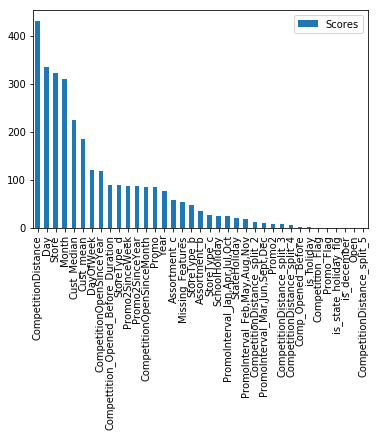

In [20]:
pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=["Scores"]).sort_values(by="Scores",ascending=False).plot.bar()

In [22]:
import lightgbm as lgb
from bayes_opt import BayesianOptimization
dtrain=lgb.Dataset(X_train,y_train.ravel())
def bo_tune_lgb(max_depth,num_leaves ,n_estimators):
    params = {'max_depth': int(round(max_depth)),
              'objective': 'regression',
              'num_leaves': int(round(num_leaves)),
              'eval_metric': 'rmse',
              'n_estimators':int(round(n_estimators))
             }
    cv_result = lgb.cv(params, dtrain,nfold=3)    
    #print(cv_result)
    #Return the negative RMSE
    return -1.0 * cv_result["l2-mean"][-1]

lgb_bo = BayesianOptimization(bo_tune_lgb, {'max_depth': (5, 100), 
                                            'num_leaves':(10,400),
                                            'n_estimators':(50,300)
                                        })

lgb_bo.maximize(init_points=5, n_iter=3)





|   iter    |  target   | max_depth | n_esti... | num_le... |
-------------------------------------------------------------
|  1        | -5.034e+0 |  28.61    |  260.4    |  273.7    |
|  2        | -6.459e+0 |  99.3     |  214.7    |  86.19    |
|  3        | -5.894e+0 |  78.95    |  90.02    |  342.5    |
|  4        | -6.727e+0 |  8.787    |  136.1    |  171.9    |
|  5        | -6.343e+0 |  48.46    |  177.3    |  114.6    |
|  6        | -5.03e+05 |  28.64    |  260.6    |  273.9    |
|  7        | -5.005e+0 |  29.72    |  267.5    |  281.6    |
|  8        | -5.001e+0 |  29.33    |  265.0    |  278.8    |


In [23]:
params = lgb_bo.max['params']

print(params)

#Conversting the max_depth and n_estimator values from float to int
params['max_depth']= int(round(params['max_depth']))
params['num_leaves']= int(round(params['num_leaves']))
params['n_estimators']= int(round(params['n_estimators']))
print(params)



{'max_depth': 29.33461731698678, 'n_estimators': 264.996210398561, 'num_leaves': 278.8313995922495}
{'max_depth': 29, 'n_estimators': 265, 'num_leaves': 279}


In [24]:
model=lgb.LGBMRegressor(**params)

model.fit(X_train,y_train)

pred=model.predict(X_test)

mean_squared_error(y_test,pred)**.5

685.1269624582372

In [25]:
model=lgb.LGBMRegressor(**params)

model.fit(X,y)

test_df["Sales"]=model.predict(test_dummies.drop("Id",axis=1))


In [26]:
closed_dates_indexes = test_df[test_df['Open']==0].index
test_df.loc[closed_dates_indexes, 'Sales'] = 0

In [27]:
test_df[["Id","Sales"]].to_csv(r"C:\Users\Gokul Mahendran\Desktop\gokul-home\Rossmann\submit2.csv",index=False)